<a href="https://colab.research.google.com/github/jaewoong-87/python/blob/master/genom_sequence_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def naive(p, t):
    occurrences = []
    for i in range(len(t) - len(p) + 1):  # loop over alignments
        match = True
        for j in range(len(p)):  # loop over characters
            if t[i+j] != p[j]:  # compare characters
                match = False
                break
        if match:
            occurrences.append(i)  # all chars matched; record
    return occurrences

In [ ]:
def reverseComplement(s):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    t = ''
    for base in s:
        t = complement[base] + t
    return t

In [ ]:
def readGenome(filename):
    genome = ''
    with open(filename, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome


In [ ]:
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename) as fh:
        while True:
            fh.readline()  # skip name line
            seq = fh.readline().rstrip()  # read base sequence
            fh.readline()  # skip placeholder line
            qual = fh.readline().rstrip() # base quality line
            if len(seq) == 0:
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities

In [ ]:
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa

--2021-02-03 10:30:58--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 65.9.76.196, 65.9.76.38, 65.9.76.64, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|65.9.76.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49270 (48K) [application/octet-stream]
Saving to: ‘lambda_virus.fa’

lambda_virus.fa     100%[===================>]  48.12K  --.-KB/s    in 0.1s    

2021-02-03 10:30:58 (325 KB/s) - ‘lambda_virus.fa’ saved [49270/49270]



In [ ]:
phix_genome=readGenome('lambda_virus.fa')

In [ ]:
occurrences = naive('ACTTAGT', phix_genome)

In [ ]:
print('offset of leftmost occurrence: %d' % min(occurrences))
print('# occurrences: %d' % len(occurrences))

offset of leftmost occurrence: 26028
# occurrences: 1


# occurrences: 150


In [ ]:
def naive_2mm(p, t):
    occurrences = []
    for i in range(len(t) - len(p) + 1):  # loop over alignments
        mismatches = 0
        match = True
        for j in range(len(p)):  # loop over characters
            if t[i+j] != p[j]:  # compare characters
                if mismatches < 2:
                    mismatches += 1
                else:
                    match = False
                    break
        if match:
            occurrences.append(i)  # all chars matched; record
    return occurrences

In [ ]:
occurrences = naive_2mm('AGGAGGTT', phix_genome)

In [ ]:
print('offset of leftmost occurrence: %d' % min(occurrences))
print('# occurrences: %d' % len(occurrences))

offset of leftmost occurrence: 49
# occurrences: 215


In [ ]:
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq

--2021-02-03 10:56:42--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 65.9.76.38, 65.9.76.123, 65.9.76.64, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|65.9.76.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241626 (236K) [application/octet-stream]
Saving to: ‘ERR037900_1.first1000.fastq’

ERR037900_1.first10 100%[===================>] 235.96K  1.01MB/s    in 0.2s    

2021-02-03 10:56:42 (1.01 MB/s) - ‘ERR037900_1.first1000.fastq’ saved [241626/241626]



In [ ]:
seqs, quals = readFastq('ERR037900_1.first1000.fastq')

In [ ]:
def phred33ToQ(qual):
    return ord(qual) - 33


    


def createHist(qualities):
    # Create a histogram of quality scores
    hist = [0]*50 # set the highest quality score as the maximum, so the position of his[x] x indicates the quality score
    for qual in qualities:
        for phred in qual:
            q = phred33ToQ(phred)
            hist[q] += 1
    return hist
h = createHist(quals)
print(h)

# h contains the frequency of each quality score

[0, 0, 17723, 0, 2, 11, 11, 28, 23, 55, 100, 111, 86, 174, 185, 272, 317, 259, 390, 1523, 2782, 762, 286, 413, 403, 538, 351, 694, 971, 777, 1024, 1449, 1341, 1312, 1916, 2233, 3025, 4043, 6640, 45696, 2074, 0, 0, 0, 0, 0, 0, 0, 0, 0]


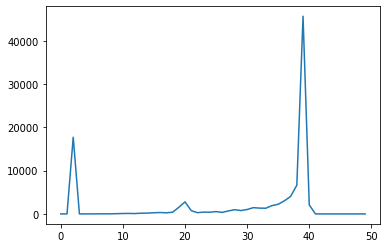

In [ ]:
# Plot the histogram
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(h)), h)
plt.show()

In [ ]:
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching. p=pattern, t=text,
        p_bm=BoyerMoore object for p """
    i = 0
    occurrences = []
    while i < len(t) - len(p) + 1:
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
    return occurrences


In [ ]:
p = 'word'
t = 'there would have been a time for such a word'
lowercase_alphabet = 'abcdefghijklmnopqrstuvwxyz '
p_bm = BoyerMoore(p, lowercase_alphabet)
occurrences, num_alignments, num_character_comparisons = boyer_moore_with_counts(p, p_bm, t)
assert(occurrences, num_alignments, num_character_comparisons) == ([40], 12, 15)

p = 'needle'
t = 'needle need noodle needle'
p_bm = BoyerMoore(p, lowercase_alphabet)
occurrences, num_alignments, num_character_comparisons = boyer_moore_with_counts(p, p_bm, t)
assert(occurrences, num_alignments, num_character_comparisons) == ([0, 19], 5, 18)

In [ ]:
!wget http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/chr1.GRCh38.excerpt.fasta

--2021-02-03 11:14:51--  http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/chr1.GRCh38.excerpt.fasta
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 13.35.253.152, 13.35.253.174, 13.35.253.86, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|13.35.253.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 810105 (791K) [application/octet-stream]
Saving to: ‘chr1.GRCh38.excerpt.fasta’

chr1.GRCh38.excerpt 100%[===================>] 791.12K  1.72MB/s    in 0.4s    

2021-02-03 11:14:52 (1.72 MB/s) - ‘chr1.GRCh38.excerpt.fasta’ saved [810105/810105]



In [ ]:
seqs, quals = readFastq('chr1.GRCh38.excerpt.fasta')

In [ ]:
def editDistance(x, y):
    # Create distance matrix
    D = []
    for i in range(len(x)+1):
        D.append([0]*(len(y)+1))
    # Initialize first row and column of matrix
    for i in range(len(x)+1):
        D[i][0] = i
    for i in range(len(y)+1):
        D[0][i] = i
    # Fill in the rest of the matrix
    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            distHor = D[i][j-1] + 1
            distVer = D[i-1][j] + 1
            if x[i-1] == y[j-1]:
                distDiag = D[i-1][j-1]
            else:
                distDiag = D[i-1][j-1] + 1
            D[i][j] = min(distHor, distVer, distDiag)
    # Edit distance is the value in the bottom right corner of the matrix
    return D[-1][-1]

In [ ]:
def readGenome(filename):
    genome = ''
    with open(filename, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

In [ ]:
genome_filename = 'chr1.GRCh38.excerpt.fasta'

t = readGenome(genome_filename)

# Question1
p = 'GCTGATCGATCGTACG'
print(editDistance(t, p))

799984


In [ ]:
p = 'GATTTACCAGATTGAG'
print(editDistance(t, p))

799984


In [ ]:
799984/2

399992.0